## Install some libraries

In [84]:
!pip install tensorflow pandas scikit-learn yfinance

In [85]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping

import yfinance as yf

pd.set_option('display.max_columns',None)

## User defined functions

In [86]:
def call_rmsle(y_true, y_pred):
    # Ensure predictions and true values are positive by adding 1
    y_true = tf.math.maximum(y_true, 0)
    y_pred = tf.math.maximum(y_pred, 0)

    # Compute the logarithm of the true and predicted values
    log_true = tf.math.log1p(y_true)
    log_pred = tf.math.log1p(y_pred)

    # Compute the squared difference
    squared_diff = tf.math.square(log_true - log_pred)

    # Compute the mean of the squared differences
    mean_squared_diff = tf.math.reduce_mean(squared_diff)

    # Return the square root of the mean squared differences
    return tf.math.sqrt(mean_squared_diff)

def remove_leading_zeros(df):
    # Find the index of the first non-zero sales value
    first_non_zero_index = df['sales'].ne(0).idxmax()

    # Filter the DataFrame to remove leading zeros
    return df.loc[first_non_zero_index:]

## Load the data

In [87]:
sgx = pd.read_csv('/Users/monilshah/Documents/02_NWU/09_MSDS_458_DL/99_group_project/StockPricePrediction/Data/Gift Nifty 50 Futures Historical Data.csv')
sgx.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,15-11-2024,"23,571.50","23,650.00","23,677.00","23,404.00",18.86K,-0.29%
1,14-11-2024,"23,641.00","23,640.50","23,752.50","23,559.00",50.24K,-0.01%
2,13-11-2024,"23,643.50","23,899.00","23,938.00","23,595.00",59.36K,-1.23%
3,12-11-2024,"23,938.00","24,225.00","24,312.00","23,855.50",46.75K,-1.17%
4,11-11-2024,"24,221.50","24,133.00","24,428.00","24,085.00",43.00K,0.09%


In [88]:

df_sgx = sgx[['Date','Open']].rename(columns={'Open':'gift_open'})

# Convert 'Date' to datetime format (considering it's in 'dd-mm-yyyy' format)
df_sgx['Date'] = pd.to_datetime(df_sgx['Date'], format='%d-%m-%Y')

# Remove commas from the 'Open' column and convert to float
df_sgx['gift_open'] = df_sgx['gift_open'].replace({',': ''}, regex=True).astype(float)
df_sgx['Date'] = pd.to_datetime(df_sgx['Date'], format='%Y-%m-%d')

df_sgx['gift_open'] = df_sgx['gift_open'].shift(1)


# Check the updated dataframe
print(df_sgx.tail())




          Date  gift_open
933 2021-04-05   14749.90
934 2021-04-01   14805.25
935 2021-03-31   14851.60
936 2021-03-30   14876.90
937 2021-03-29   14727.00


In [89]:
#df_train_all    = pd.read_csv('data/SPX.csv')

start_date = "2021-01-01"
end_date   = "2024-11-16"

data = yf.download("^NSEI", start=start_date, end=end_date)
data.columns = data.columns.get_level_values(0) # from multi index to single index

data = data.reset_index()


print(data.head())



[*********************100%***********************]  1 of 1 completed

Price                      Date     Adj Close         Close          High  \
0     2021-01-01 00:00:00+00:00  14018.500000  14018.500000  14049.849609   
1     2021-01-04 00:00:00+00:00  14132.900391  14132.900391  14147.950195   
2     2021-01-05 00:00:00+00:00  14199.500000  14199.500000  14215.599609   
3     2021-01-06 00:00:00+00:00  14146.250000  14146.250000  14244.150391   
4     2021-01-07 00:00:00+00:00  14137.349609  14137.349609  14256.250000   

Price           Low          Open  Volume  
0      13991.349609  13996.099609  358100  
1      13953.750000  14104.349609  495000  
2      14048.150391  14075.150391  492500  
3      14039.900391  14240.950195  632300  
4      14123.099609  14253.750000  559200  


In [90]:
data.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [91]:

data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
data['Date'] = pd.to_datetime(data['Date']).dt.date
#data.set_index('Date', inplace=True)


df_train_all = data.copy()


In [92]:
df_train_all['Date'] = pd.to_datetime(df_train_all['Date'], format='%Y-%m-%d')


df_train_all         = df_train_all.merge(df_sgx, how = 'left', on = 'Date' )
df_train_all.tail()


,Date,Adj Close,Close,High,Low,Open,Volume,gift_open
952,2024-11-08,24148.199219,24148.199219,24276.150391,24066.650391,24207.699219,298700,24133.0
953,2024-11-11,24141.300781,24141.300781,24336.800781,24004.599609,24087.250000,273400,24225.0
954,2024-11-12,23883.449219,23883.449219,24242.000000,23839.150391,24225.800781,255800,23899.0
955,2024-11-13,23559.050781,23559.050781,23873.599609,23509.599609,23822.449219,304600,23640.5
956,2024-11-14,23532.699219,23532.699219,23675.900391,23484.150391,23542.150391,257700,23650.0


## Feature engineering

In [93]:
df_train_all['10DMA'] =  df_train_all['Adj Close'].rolling(window=10).mean()
df_train_all['30DMA'] =  df_train_all['Adj Close'].rolling(window=30).mean()
df_train_all['100DMA'] =  df_train_all['Adj Close'].rolling(window=100).mean()

df_train_all.dropna(subset=['100DMA'], inplace=True)

In [94]:
import calendar
from datetime import datetime, timedelta
def is_last_thursday(date):
    year = date.year
    month = date.month
    
    last_day = calendar.monthrange(year, month)[1]
    last_date = datetime(year, month, last_day)
    last_day_weekday = last_date.weekday()
    days_since_last_thursday = (last_day_weekday - calendar.THURSDAY) % 7
    last_thursday_date = last_date - timedelta(days=days_since_last_thursday)
    
    return 1 if date.date() == last_thursday_date.date() else 0




In [95]:
df_train_all.columns


Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'gift_open', '10DMA', '30DMA', '100DMA'],
      dtype='object')

In [96]:
df_train_all['Date'] = pd.to_datetime(df_train_all['Date'])


df_train_all['day'] = df_train_all['Date'].dt.strftime("%A")
le_day = LabelEncoder()
df_train_all['day'] = le_day.fit_transform(df_train_all['day'])

df_train_all['date_no'] = df_train_all['Date'].dt.day
df_train_all['month'] = df_train_all['Date'].dt.month
df_train_all['year'] = df_train_all['Date'].dt.year

df_train_all['opt_exp'] = df_train_all['Date'].apply(is_last_thursday)
df_train_all['year'] = df_train_all['year'] - df_train_all['year'].min()


In [97]:


# Convert month and day to cyclical features
#df_train_all['month_sin'] = np.sin(2 * np.pi * df_train_all['month'] / 12)
#df_train_all['month_cos'] = np.cos(2 * np.pi * df_train_all['month'] / 12)
#df_train_all['day_sin'] = np.sin(2 * np.pi * df_train_all['day'] / 31)
#df_train_all['day_cos'] = np.cos(2 * np.pi * df_train_all['day'] / 31)



In [98]:
df_train_all['next_close'] = df_train_all['Close'].shift(-1)
df_train_all['target'] = df_train_all['next_close'] - df_train_all['Close']
df_train_all.dropna(subset=['target'], inplace=True)

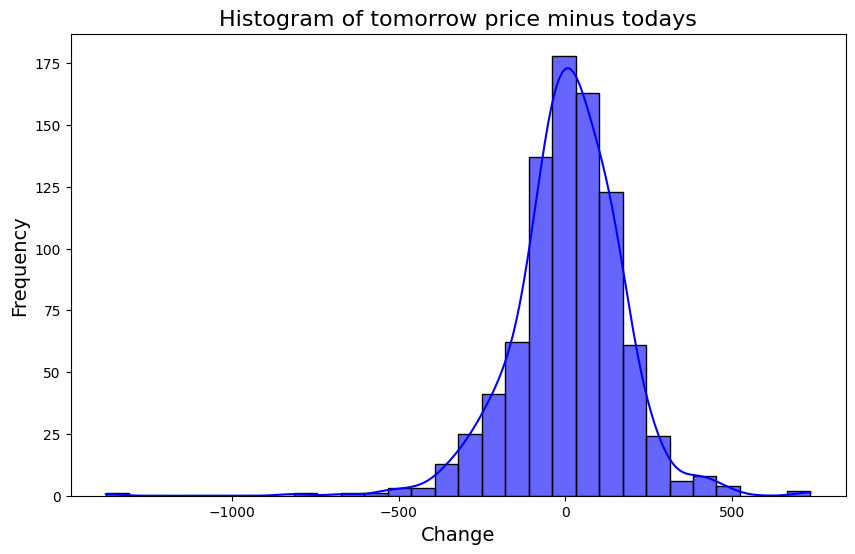

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_train_all['target'].dropna(), bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of tomorrow price minus todays', fontsize=16)
plt.xlabel('Change', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


In [100]:
skewness = df_train_all['target'].skew()
print(f"Skewness of target: {skewness}")


Skewness of target: -0.8486050868102658


### Show how min max transform will preserve the original distribution

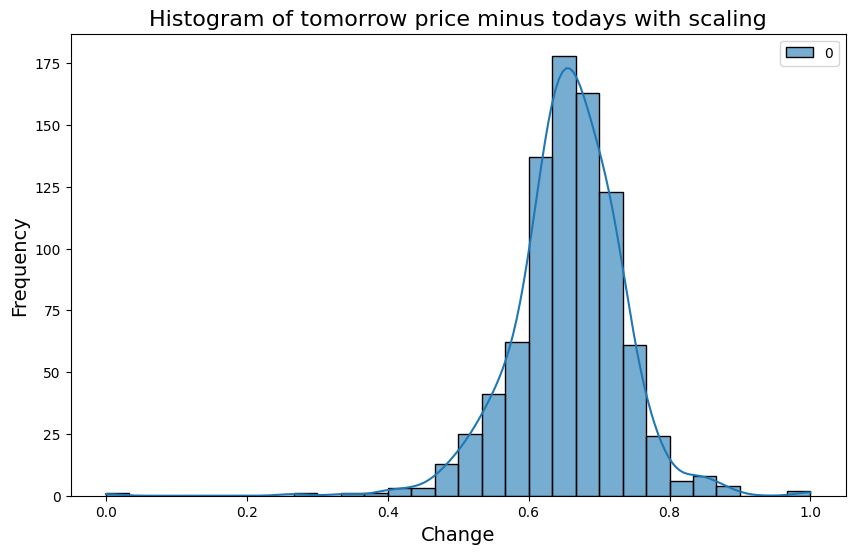

In [101]:
mm = MinMaxScaler()
ss = mm.fit_transform(df_train_all[['target']])

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(ss, bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of tomorrow price minus todays with scaling', fontsize=16)
plt.xlabel('Change', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

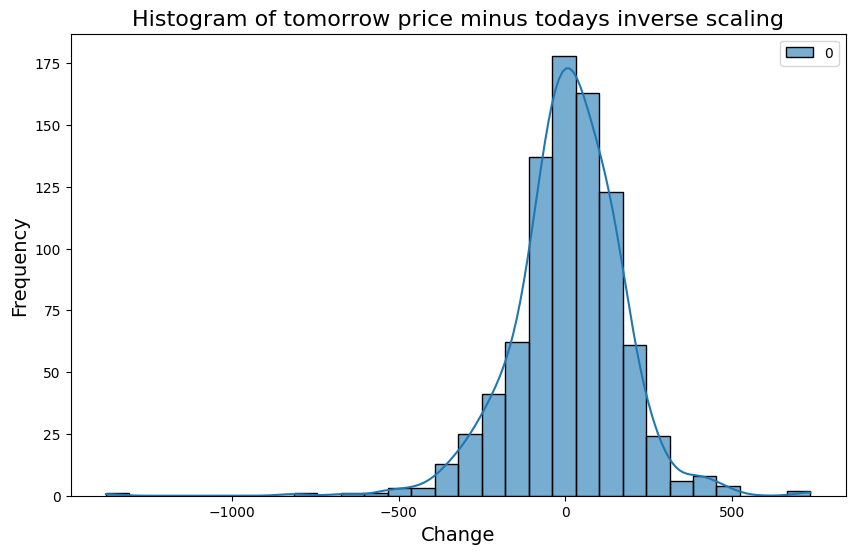

In [102]:
ss_inv = mm.inverse_transform(ss)

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(ss_inv, bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of tomorrow price minus todays inverse scaling', fontsize=16)
plt.xlabel('Change', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

### Back on route

In [103]:
df_train_all.head()

,Date,Adj Close,Close,High,Low,Open,Volume,gift_open,10DMA,30DMA,100DMA,day,date_no,month,year,opt_exp,next_close,target
99,2021-05-31,15582.799805,15582.799805,15606.349609,15374.000000,15437.750000,436000,15635.35,15228.350000,14840.676660,14736.996982,1,31,5,0,0,15574.849609,-7.950195
100,2021-06-01,15574.849609,15574.849609,15660.750000,15528.299805,15629.650391,409600,15567.10,15275.025000,14872.576660,14752.560479,3,1,6,0,0,15576.200195,1.350586
101,2021-06-02,15576.200195,15576.200195,15597.450195,15459.849609,15520.349609,428600,15709.85,15329.629980,14913.134993,14766.993477,4,2,6,0,0,15690.349609,114.149414
102,2021-06-03,15690.349609,15690.349609,15705.099609,15611.000000,15655.549805,410200,15687.40,15408.059961,14959.599967,14781.901973,2,3,6,0,0,15670.250000,-20.099609
103,2021-06-04,15670.250000,15670.250000,15733.599609,15622.349609,15712.500000,414200,15728.45,15457.554980,15001.736621,14797.141973,0,4,6,0,0,15751.650391,81.400391


In [104]:
#df_train_all['price_next'] = df_train_all['Close'].shift(-1)
df_train_all['prev_close'] = df_train_all['Close'].shift(1)

df_train_all['pct_change_in_a_day'] = df_train_all['Close']/df_train_all['Open']  
df_train_all['act_change_in_a_day'] = df_train_all['Close']-df_train_all['Open']
df_train_all['opening_gap'] = df_train_all['Open'] - df_train_all['prev_close'] 
df_train_all['daily_move'] = df_train_all['High'] - df_train_all['Low']
#df_train_all['daily_move']= df_train_all['daily_move'].shift(1) #previous day daily movement
df_train_all['range_avg'] =  df_train_all['daily_move'].rolling(window=5).mean() #average of last 5 day movement
df_train_all['change_avg'] =  df_train_all['act_change_in_a_day'].rolling(window=5).mean()
#df_train_all['price_lag2'] = df_train_all['Adj Close'].shift(2)
#df_train_all['price_lag3'] = df_train_all['Adj Close'].shift(3)
#df_train_all['price_lag4'] = df_train_all['Adj Close'].shift(4)
#df_train_all['price_lag5'] = df_train_all['Adj Close'].shift(5)
#df_train_all.dropna(subset=['price_lag5'], inplace=True)

In [106]:
df_train_all.tail()

,Date,Adj Close,Close,High,Low,Open,Volume,gift_open,10DMA,30DMA,100DMA,day,date_no,month,year,opt_exp,next_close,target,prev_close,pct_change_in_a_day,act_change_in_a_day,opening_gap,daily_move,range_avg,change_avg
951,2024-11-07,24199.349609,24199.349609,24503.349609,24179.050781,24489.599609,322200,24331.5,24272.940039,24819.966602,24703.579961,2,7,11,3,0,24148.199219,-51.150391,24484.050781,0.988148,-290.250000,5.548828,324.298828,326.559766,-27.389844
952,2024-11-08,24148.199219,24148.199219,24276.150391,24066.650391,24207.699219,298700,24133.0,24269.679883,24751.038216,24709.482949,0,8,11,3,0,24141.300781,-6.898438,24199.349609,0.997542,-59.500000,8.349609,209.500000,350.849609,-39.609766
953,2024-11-11,24141.300781,24141.300781,24336.800781,24004.599609,24087.250000,273400,24225.0,24249.894922,24683.116602,24715.735957,1,11,11,3,0,23883.449219,-257.851562,24148.199219,1.002244,54.050781,-60.949219,332.201172,317.169922,35.280469
954,2024-11-12,23883.449219,23883.449219,24242.000000,23839.150391,24225.800781,255800,23899.0,24191.554883,24618.869922,24718.900449,3,12,11,3,0,23559.050781,-324.398438,24141.300781,0.985868,-342.351562,84.500000,402.849609,320.479688,-92.550000
955,2024-11-13,23559.050781,23559.050781,23873.599609,23509.599609,23822.449219,304600,23640.5,24113.375000,24544.274935,24719.479961,4,13,11,3,0,23532.699219,-26.351562,23883.449219,0.988943,-263.398438,-61.000000,364.000000,326.569922,-180.289844


In [109]:
split_date   = '2024-03-31'

df_train = df_train_all[df_train_all['Date']<=  split_date] #keeping 4 years for training 
df_test  = df_train_all[df_train_all['Date']>  split_date] #keeping last year for testing

In [110]:
df_lstm_results  = pd.DataFrame()

In [111]:
df_test.tail()

,Date,Adj Close,Close,High,Low,Open,Volume,gift_open,10DMA,30DMA,100DMA,day,date_no,month,year,opt_exp,next_close,target,prev_close,pct_change_in_a_day,act_change_in_a_day,opening_gap,daily_move,range_avg,change_avg
951,2024-11-07,24199.349609,24199.349609,24503.349609,24179.050781,24489.599609,322200,24331.5,24272.940039,24819.966602,24703.579961,2,7,11,3,0,24148.199219,-51.150391,24484.050781,0.988148,-290.250000,5.548828,324.298828,326.559766,-27.389844
952,2024-11-08,24148.199219,24148.199219,24276.150391,24066.650391,24207.699219,298700,24133.0,24269.679883,24751.038216,24709.482949,0,8,11,3,0,24141.300781,-6.898438,24199.349609,0.997542,-59.500000,8.349609,209.500000,350.849609,-39.609766
953,2024-11-11,24141.300781,24141.300781,24336.800781,24004.599609,24087.250000,273400,24225.0,24249.894922,24683.116602,24715.735957,1,11,11,3,0,23883.449219,-257.851562,24148.199219,1.002244,54.050781,-60.949219,332.201172,317.169922,35.280469
954,2024-11-12,23883.449219,23883.449219,24242.000000,23839.150391,24225.800781,255800,23899.0,24191.554883,24618.869922,24718.900449,3,12,11,3,0,23559.050781,-324.398438,24141.300781,0.985868,-342.351562,84.500000,402.849609,320.479688,-92.550000
955,2024-11-13,23559.050781,23559.050781,23873.599609,23509.599609,23822.449219,304600,23640.5,24113.375000,24544.274935,24719.479961,4,13,11,3,0,23532.699219,-26.351562,23883.449219,0.988943,-263.398438,-61.000000,364.000000,326.569922,-180.289844


In [112]:
df_train.dropna(subset=['range_avg'], inplace=True)
df_train.dropna(subset=['gift_open'], inplace=True)
df_train.columns

/var/folders/ws/v15jk6j56z90j1tz393rgysw0000gn/T/ipykernel_19233/637183717.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.dropna(subset=['range_avg'], inplace=True)
/var/folders/ws/v15jk6j56z90j1tz393rgysw0000gn/T/ipykernel_19233/637183717.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.dropna(subset=['gift_open'], inplace=True)


Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'gift_open', '10DMA', '30DMA', '100DMA', 'day', 'date_no', 'month',
       'year', 'opt_exp', 'next_close', 'target', 'prev_close',
       'pct_change_in_a_day', 'act_change_in_a_day', 'opening_gap',
       'daily_move', 'range_avg', 'change_avg'],
      dtype='object')

In [113]:
          
df = df_train.copy()
df.drop('Date',axis = 1, inplace = True)
###########################################################################################
###############     Preparing for LSTM              ######################################
#########################################################################################

# Features to be scaled
features_to_scale = ['Close', 'High', 'Low', 'Open', 'Volume',
                    'gift_open', '10DMA', '30DMA', '100DMA', 'day', 'date_no',
                    'pct_change_in_a_day', 'act_change_in_a_day', 'opening_gap',
                    'daily_move', 'range_avg', 'change_avg']

features_to_scale = [ 'Volume', 'Close',  
                     'act_change_in_a_day',
                     'range_avg', 'change_avg']


# Features to be left unscaled (those ending with 'sin' or 'cos')
#features_to_leave = ['opt_exp','month_sin','month_cos','day_sin','day_cos' ]
features_to_leave = ['opt_exp' ]

df[features_to_scale].head()

,Volume,Close,act_change_in_a_day,range_avg,change_avg
103,414200,15670.250000,-42.250000,141.550000,27.729883
104,394000,15751.650391,26.550781,114.150195,4.030078
105,378200,15740.099609,-33.800781,107.420117,8.230078
106,457900,15635.349609,-130.950195,126.609961,-29.130078
107,298300,15737.750000,45.650391,128.340039,-26.959961


In [114]:

features = features_to_scale + features_to_leave
#target = 'price_next'
target = 'target'

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, shuffle=False)

#X_train = df[features]
#y_train = df[target]
# Initialize scalers
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale only the selected features
X_train_scaled_part = feature_scaler.fit_transform(X_train[features_to_scale])
X_test_scaled_part = feature_scaler.transform(X_test[features_to_scale])

# Combine scaled features with unscaled features (still as NumPy arrays)
X_train_scaled = np.hstack((X_train_scaled_part, X_train[features_to_leave].values))
X_test_scaled = np.hstack((X_test_scaled_part, X_test[features_to_leave].values))

# Scale target variable
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

print("X_train_reshaped shape:", X_train_scaled.shape)
print("y_train_reshaped shape:", y_train_scaled.shape)
print("X_test_reshaped shape:", X_test_scaled.shape)
print("y_test_reshaped shape:", y_test_scaled.shape)



X_train_reshaped shape: (557, 6)
y_train_reshaped shape: (557, 1)
X_test_reshaped shape: (140, 6)
y_test_reshaped shape: (140, 1)


In [115]:

timesteps = 60



In [ ]:

# Function to create sequences for LSTM
def create_sequences(data, target, timesteps):
    sequences = []
    targets = []
    for i in range(len(data) - timesteps + 1):
        sequences.append(data[i:i+timesteps, :])
        targets.append(target[i+timesteps-1])  # Use the last value in the window as the target
    return np.array(sequences), np.array(targets)

# Create LSTM-compatible sequences
X_train_reshaped, y_train_reshaped = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_reshaped, y_test_reshaped = create_sequences(X_test_scaled, y_test_scaled, timesteps)

# Check shapes
print("X_train_reshaped shape:", X_train_reshaped.shape)
print("y_train_reshaped shape:", y_train_reshaped.shape)
print("X_test_reshaped shape:", X_test_reshaped.shape)
print("y_test_reshaped shape:", y_test_reshaped.shape)



X_train_reshaped shape: (498, 60, 6)
y_train_reshaped shape: (498, 1)
X_test_reshaped shape: (81, 60, 6)
y_test_reshaped shape: (81, 1)


In [117]:

# Build your LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=(timesteps, X_train_reshaped.shape[2]))))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.1))
model.add(Dense(25))
model.add(Dropout(0.1))

model.add(Dense(1))

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model with RMSLE as the loss function
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae','mse'])

# Train the model
history = model.fit(X_train_reshaped, 
                    y_train_reshaped, 
                    epochs=100, 
                    validation_data=(X_test_reshaped, y_test_reshaped), 
                    batch_size=32,
                    callbacks=[early_stopping])


Epoch 1/100


/opt/anaconda3/envs/Conda_3_12_7/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.1181 - mae: 0.2678 - mse: 0.1181 - val_loss: 0.0358 - val_mae: 0.1548 - val_mse: 0.0358
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0234 - mae: 0.1185 - mse: 0.0234 - val_loss: 0.0256 - val_mae: 0.1250 - val_mse: 0.0256
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0207 - mae: 0.1157 - mse: 0.0207 - val_loss: 0.0250 - val_mae: 0.1231 - val_mse: 0.0250
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0198 - mae: 0.1105 - mse: 0.0198 - val_loss: 0.0176 - val_mae: 0.1015 - val_mse: 0.0176
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0180 - mae: 0.1057 - mse: 0.0180 - val_loss: 0.0166 - val_mae: 0.1020 - val_mse: 0.0166
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0176 - mae: 0.1017 - mse: 0.0176 - val_loss: 0.0174 - val_mae: 0.1013 - val_mse: 0.0174
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0194 - mae: 0.1096 - mse: 0.0194 - val_loss: 0.01

In [ ]:

##############################################################################################
#########################          Checking val performance              #############################
##############################################################################################


# Predictions
lstm_predictions = model.predict(X_test_reshaped)
lstm_predictions = lstm_predictions.reshape(-1,1)

# Ensure both predictions and actual values are of type float64
y_test_reshaped = y_test_reshaped.reshape(-1, 1).astype('float64')
lstm_predictions_scaled = lstm_predictions.astype('float64')


y_test_actual = target_scaler.inverse_transform(y_test_reshaped).astype('float64')
lstm_predictions_actual = target_scaler.inverse_transform(lstm_predictions_scaled).astype('float64')
results_test_unscaled   = model.evaluate(X_test_reshaped, y_test_reshaped)
print("Validation performance: ",results_test_unscaled)

#

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0151 - mae: 0.0977 - mse: 0.0151
Validation performance:  [0.01540660671889782, 0.09898683428764343, 0.01540660671889782]


## Applying model on Test Data

In [119]:
#############################################################################################
#########################             Applying model on test data       ######################
##############################################################################################

del df
df   = df_test.copy()
#df = df_train_all.copy()  #change 1: to make prediction on whole data

df.drop('Date',axis = 1, inplace = True)
###########################################################################################
###############     Preparing for LSTM              ######################################
#########################################################################################


# Scale only the selected features
X_test_scaled_part        = feature_scaler.transform(df[features_to_scale])

# Combine scaled features with unscaled features (still as NumPy arrays)
X_test_scaled             = np.hstack((X_test_scaled_part, df[features_to_leave].values))
#X_test_reshaped           = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))

y_test_scaled             = target_scaler.transform(df['target'].values.reshape(-1, 1))


X_test_reshaped, y_test_reshaped = create_sequences(X_test_scaled, y_test_scaled, timesteps)

# Check shapes
print("X_test_reshaped shape:", X_test_reshaped.shape)
print("y_test_reshaped shape:", y_test_reshaped.shape)


test_performance          = model.evaluate(X_test_reshaped, y_test_reshaped)
print("Test performance (MAE): ", test_performance[1])





X_test_reshaped shape: (96, 60, 6)
y_test_reshaped shape: (96, 1)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0219 - mae: 0.1055 - mse: 0.0219
Test performance (MAE):  0.11167887598276138


In [120]:
model.predict(X_test_reshaped).shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


(96, 1)

In [121]:
df_test.shape[0] - lstm_predictions_actual.shape[0]

74

In [122]:
# Predictions
lstm_predictions         = model.predict(X_test_reshaped)
lstm_predictions_scaled  = lstm_predictions.astype('float64')

lstm_predictions_actual = target_scaler.inverse_transform(lstm_predictions_scaled).astype('float64')

df_test_prediction      = df_test[(timesteps- 1):].copy() 
#df_test_prediction      = df_train_all[(timesteps- 1):].copy() #change 2: to make prediction on whole data

# Add predictions to the dataframe
df_test_prediction['change_predicted'] = lstm_predictions_actual



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [123]:

df_test_prediction['predicted_close'] = df_test_prediction['Close'] + df_test_prediction['change_predicted']

In [124]:
df_test_prediction.dropna(subset=['predicted_close'], inplace=True)

In [125]:
df_test_prediction['prediction_diff'] =  df_test_prediction['predicted_close']-df_test_prediction['next_close']
df_test_prediction['pct_prediction_diff'] = df_test_prediction['prediction_diff']/df_test_prediction['next_close']*100

df_test_prediction[['next_close','predicted_close','prediction_diff','pct_prediction_diff']]


,next_close,predicted_close,prediction_diff,pct_prediction_diff
860,24141.949219,24067.096390,-74.852829,-0.310053
861,24123.849609,24187.197944,63.348334,0.262596
862,24286.500000,24142.556433,-143.943567,-0.592690
863,24302.150391,24283.540878,-18.609512,-0.076576
864,24323.849609,24291.665688,-32.183921,-0.132314
...,...,...,...,...
951,24148.199219,24239.070377,90.871159,0.376306
952,24141.300781,24191.583863,50.283082,0.208287
953,23883.449219,24187.153808,303.704589,1.271611
954,23559.050781,23919.235706,360.184925,1.528860


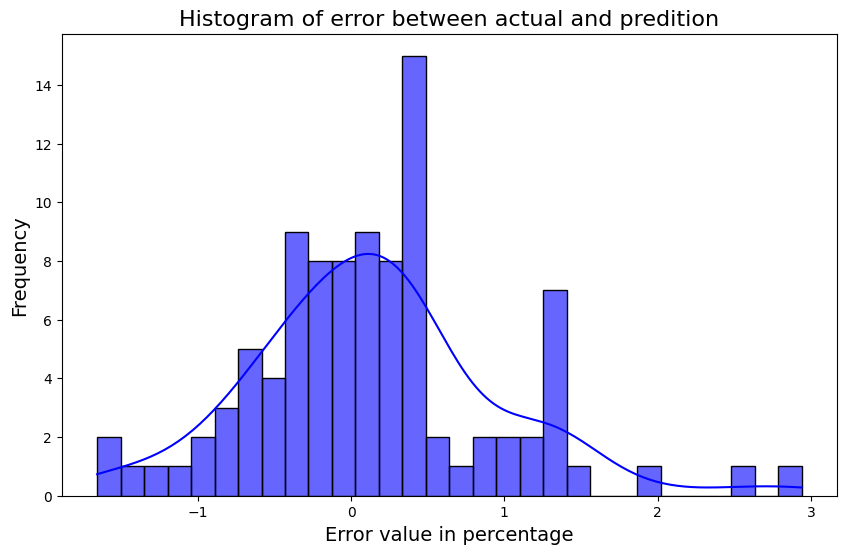

In [126]:
# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_test_prediction['pct_prediction_diff'], bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of error between actual and predition', fontsize=16)
plt.xlabel('Error value in percentage', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

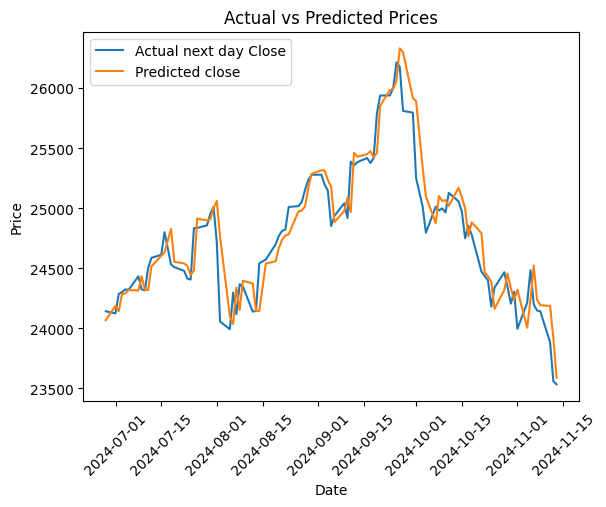

In [127]:
import matplotlib.pyplot as plt

# Plot the actual prices ('Close') and the predicted prices ('predicted_close')
plt.plot(df_test_prediction['Date'], df_test_prediction['next_close'], label='Actual next day Close')
plt.plot(df_test_prediction['Date'], df_test_prediction['predicted_close'], label='Predicted close')

# Add a title, labels, and legend
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

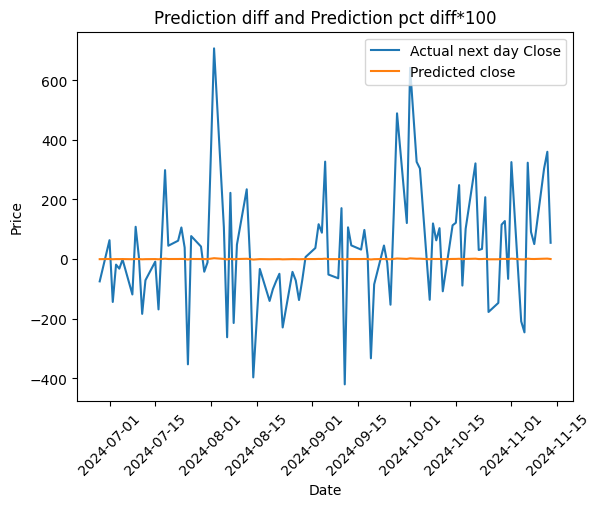

In [128]:
import matplotlib.pyplot as plt

# Plot the actual prices ('Close') and the predicted prices ('predicted_close')
plt.plot(df_test_prediction['Date'], df_test_prediction['prediction_diff'], label='Actual next day Close')
plt.plot(df_test_prediction['Date'], df_test_prediction['pct_prediction_diff'], label='Predicted close')

# Add a title, labels, and legend
plt.title('Prediction diff and Prediction pct diff*100')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [129]:
print("average percentage difference", df_test_prediction['pct_prediction_diff'].abs().mean())
print("average points difference", df_test_prediction['prediction_diff'].abs().mean())

average percentage difference 0.5989152325639087
average points difference 147.9687304863643


In [130]:
needed_columns = ['Date', 'next_close', 'predicted_close', 'prediction_diff', 'pct_prediction_diff']

df_test_sample = df_test_prediction[needed_columns]


# Generate new column names
new_columns = {col: f"{col}_{timesteps}" for col in needed_columns[2:]}

# Rename the columns in the DataFrame (excluding 'Date')
df_test_sample = df_test_sample.rename(columns=new_columns)


In [131]:
save_wip_folder  = '/Users/monilshah/Documents/02_NWU/09_MSDS_458_DL/99_group_project/StockPricePrediction/MSDS_458_Group_N/03_LSTM_timeseries/WIP_files/' 
file_name        = 'predictions_'+str(timesteps) + '.csv'
save_wip         = save_wip_folder + file_name

df_test_sample.to_csv(save_wip)

In [132]:
df_test_sample.head()

,Date,next_close,predicted_close_60,prediction_diff_60,pct_prediction_diff_60
860,2024-06-28,24141.949219,24067.096390,-74.852829,-0.310053
861,2024-07-01,24123.849609,24187.197944,63.348334,0.262596
862,2024-07-02,24286.500000,24142.556433,-143.943567,-0.592690
863,2024-07-03,24302.150391,24283.540878,-18.609512,-0.076576
864,2024-07-04,24323.849609,24291.665688,-32.183921,-0.132314


In [137]:
print("Average prediction error :", round(df_test_sample['pct_prediction_diff_60'].abs().mean(),2), "%")

Average prediction error : 0.6 %
